In [1]:
import os
base = "/data/bionets" if "ramses" in os.uname()[1] else "/data_nfs/"

import cv2 
import sys
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import torch as t
from tqdm import tqdm

os.environ["CUDA_VISIBLE_DEVICES"]="1"
sys.path.append("..")
from src import *

2024-06-25 14:19:05.980439: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-25 14:19:06.025074: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-25 14:19:06.873418: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
config_path = "../config.json"
with open(config_path, "r") as f:
    configs = json.load(f)
    dataset_statistics = configs["dataset_statistics"]
    checkpoint_path = configs["model_weights"]
    pretrained_model_path = configs["pretrained_model_path"]

In [4]:
markers = ['ADAM10', 'Bcl-2', 'CD10', 'CD107a', 'CD13', 'CD138', 'CD14', 'CD1a', 'CD2', 'CD25', 'CD271', 'CD3', 'CD36', 'CD4', 'CD44', 'CD45', 'CD45RA', 'CD45RO', 'CD5', 'CD56', 'CD6', 'CD63', 'CD66abce', 'CD7', 'CD71', 'CD8', 'CD9', 'CD95', 'Collagen IV', 'Cytokeratin-14', 'EBF-P', 'EGFR', 'EGFR-AF488', 'HLA-ABC', 'HLA-DR', 'KIP1', 'Ki67', 'L302', 'MCSP', 'Melan-A', 'Nestin-AF488', 'Notch-1', 'Notch-3', 'PPARgamma', 'PPB', 'RIM3', 'TAP73', 'Vimentin', 'p63', 'phospho-Connexin', "Propidium iodide"]    

In [5]:
data = get_data_csv(high_quality_only=True, pfs=True, config_path=os.path.join("/data_nfs", "je30bery/melanoma_data/config.json"))
data = data.reset_index().drop("index", axis=1)

In [6]:
len(data)

54

In [7]:
rois = [os.path.splitext(f)[0][7:] for f in os.listdir("../data/ROIs/ground_truth_ROI/filled") if "filled" in f]
data = data[data["file_path"].isin(rois)]
#data = data[data["file_path"] == 'Melanoma_35_202009031055_3']

In [8]:
splits = {
    0: ['B513'],
    1: ['B279'],
    2: ['B484'],
    3: ['B033', 'B032', 'B031', 'B029', 'B030'],
    4: ['B104'],
    5: ['B148'],
    6: ['B196'],
    7: ['B407'],
    8: ['B217'],
    9: ['B515'],
    10: ['B023'],
    11: ['B168'],
    12: ['B345'],
    13: ['B397'],
    14: ['B096'],
    15: ['B502', 'B503'],
    16: ['B390'],
    17: ['B218'],
    18: ['B488', 'B487'],
    19: ['B274'],
    20: ['B462'],
    21: ['B497']
}

In [9]:
print(len(data))

12


In [10]:
try:
    gcs = np.load("gcs.npy")
except:
    model = ResNet18_smoothgrad(indim=len(markers), cam=True, checkpoint_path=checkpoint_path)
    model = model.to("cuda:0")
    finetuned_models_path = "../src/model/final_finetuned_models/"
    finetuned_models = os.listdir(finetuned_models_path)
    gcs = list()
    filepaths = list()
    for split in tqdm(splits):
        data_subset = data[data["Histo-ID"].isin(splits[split])]
        if len(data_subset) == 0:
            continue
        filepaths.append(data_subset["file_path"].values)
        dl = t.utils.data.DataLoader(MelanomaData(markers, pretrain=False, data=data_subset, mode="val", config_path=config_path), batch_size=1, shuffle=False)
        model_path = [m for m in finetuned_models if f"split={split}" in m][0]
        model.load_state_dict(t.load(os.path.join(finetuned_models_path, model_path), map_location="cuda:0"), strict=True)
        model.eval()
        noise_correction = get_smooth_grad(None, model, cuda=True, n_smooth=20, noise_std=0.15)
        corrector = np.mean(noise_correction, axis=-1)
        #corrector /= np.max(corrector)
        gc = get_smooth_grad(dl, model, cuda=True, n_smooth=10, noise_std=0.15)
        for i in range(gc.shape[-1]):
            gradcam = gc[:,:,i] 
            gradcam /= np.max(gradcam)
            corrected = gradcam - corrector
            corrected = np.where(corrected > 0, corrected, 0)
            gcs.append(corrected)
    filepaths = np.concatenate(filepaths)
    np.save("gcs.npy", np.stack(gcs))

In [11]:
model = ResNet18_pretrained(indim=len(markers), cam=True, checkpoint_path=checkpoint_path)
model = model.to("cuda:0")
model.load_state_dict(t.load(pretrained_model_path, map_location="cuda:0"), strict=True)
model.eval()

base_gcs = list()
base_filepaths = data["file_path"]

dl = t.utils.data.DataLoader(MelanomaData(markers, pretrain=True, data=data, mode="val", config_path=config_path), batch_size=1, shuffle=False)

noise_correction = get_smooth_grad(None, model, cuda=True, n_smooth=20, noise_std=0.15)
corrector = np.mean(noise_correction, axis=-1)
#corrector /= np.max(corrector)
gc = get_smooth_grad(dl, model, cuda=True, n_smooth=10, noise_std=0.15)
for i in range(gc.shape[-1]):
    gradcam = gc[:,:,i] 
    gradcam /= (np.max(gradcam) + 1e-5)
    corrected = gradcam - corrector
    corrected = np.where(corrected > 0, corrected, 0)
    base_gcs.append(corrected)

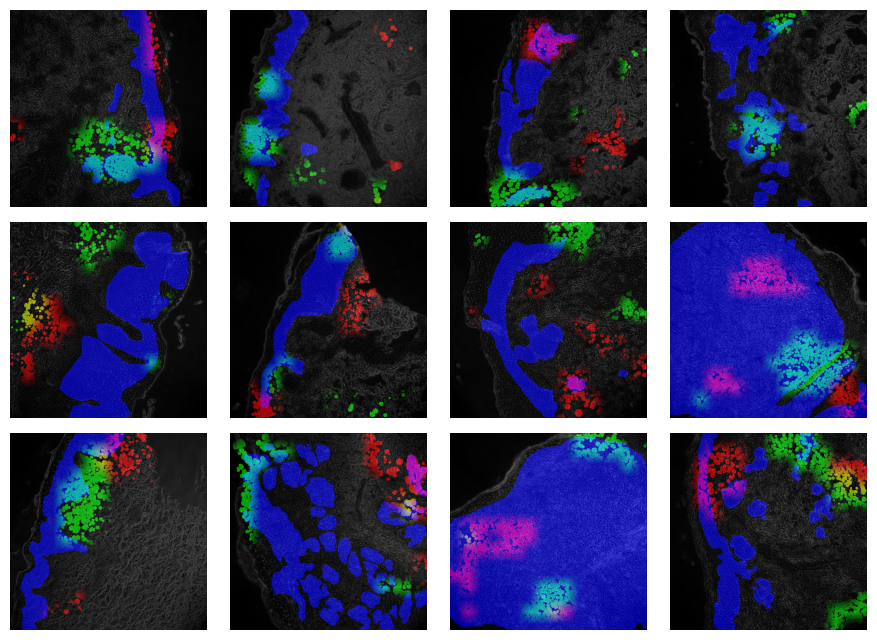

In [88]:
f, axs = plt.subplots(3, 4, figsize=(9, 6.5))

binaries = list()
quantile = 0.9
data_path = "/data_nfs/datasets/melc/melanoma"
for i, filepath in enumerate(base_filepaths):
    y = i % axs.shape[-1]
    x = i // axs.shape[-1]
    ax = axs[x, y] #TODO
    #ax = axs
    if filepath in rois:
        roi = cv2.imread(f"../data/ROIs/ground_truth_ROI/filled/filled_{filepath}.tif", cv2.IMREAD_GRAYSCALE)
        roi = cv2.resize(roi, (512, 512))
    else:
        roi = -1

    segmented = os.path.join(base, "datasets/melc/melanoma/", "segmented", f'{filepath}_cells.npy')
    with open(segmented, "rb") as openfile:
        seg_file = np.load(openfile) > 0
    seg_file = cv2.resize(seg_file.astype(np.uint8), (512, 512))
    
    gc = gcs[i] #- correction
    bin = np.where(gc > np.quantile(gc, quantile), 255, 0).astype(np.uint8)
    gc = cv2.resize(bin, (512, 512)) * seg_file #, interpolation=cv2.INTER_AREA)

    base_gc = base_gcs[i]
    bin = np.where(base_gc > np.quantile(base_gc, quantile), 255, 0).astype(np.uint8)
    base_gc = cv2.resize(bin, (512, 512)) * seg_file #, interpolation=cv2.INTER_CUBIC)

    phase = cv2.imread([os.path.join(data_path, "processed", filepath, f) for f in os.listdir(os.path.join(data_path, "processed", filepath)) if "phase.tif" in f.lower()][0])
    phase = cv2.resize(phase, (512, 512), interpolation=cv2.INTER_AREA)
    ax.imshow(rgb_on_background(r=base_gc, g=gc, b=roi, background=phase))
    ax.axis("off")
    #ax.set_title(data.set_index("file_path").loc[filepath]["PFS label"])
axs[-1, -1].axis("off") # TO
plt.tight_layout()
plt.savefig("model_rois.pdf")